In [ ]:
!pip3 install torch
!pip3 install matplotlib

#### Necessary Imports

In [4]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

#### Creating The Lookup Table

In [5]:
words = open('names.txt', 'r').read().splitlines()

In [6]:
# Creating lookup table
N = torch.zeros((27, 27), dtype=torch.int32)
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1, ix2 = stoi[ch1], stoi[ch2]
    N[ix1, ix2] += 1

#### Visualizing The Lookup Table

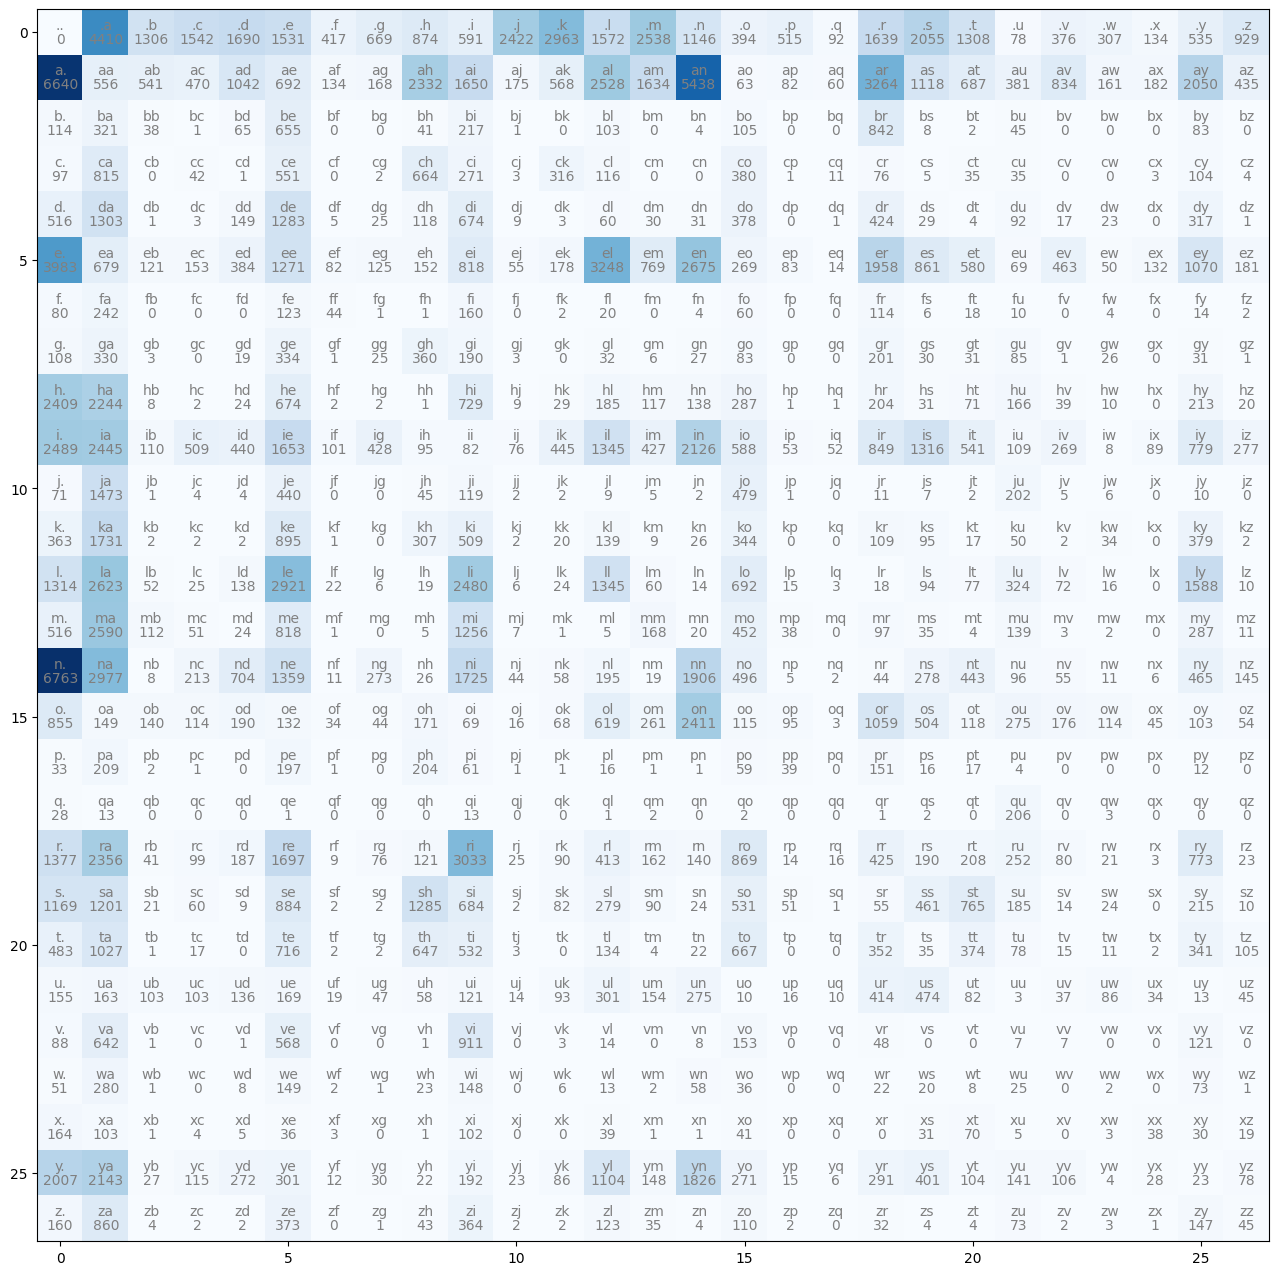

In [7]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
  for j in range(27):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
    plt.text(j, i, N[i,j].item(), ha='center', va='top', color='gray')

## Probability Distribution Method

#### Sampling from the Lookup Table

In [11]:
# Creating a propability distibution vectors (for each row)
P = (N+1).float()
P = P / P.sum(dim=1, keepdim=True)

g = torch.Generator().manual_seed(2147483647) # generator to ensure deterministic values

for i in range(5):
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # Drawing 1 sample based off the distribution
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.


#### Visualizing The Probability Density By Row Table

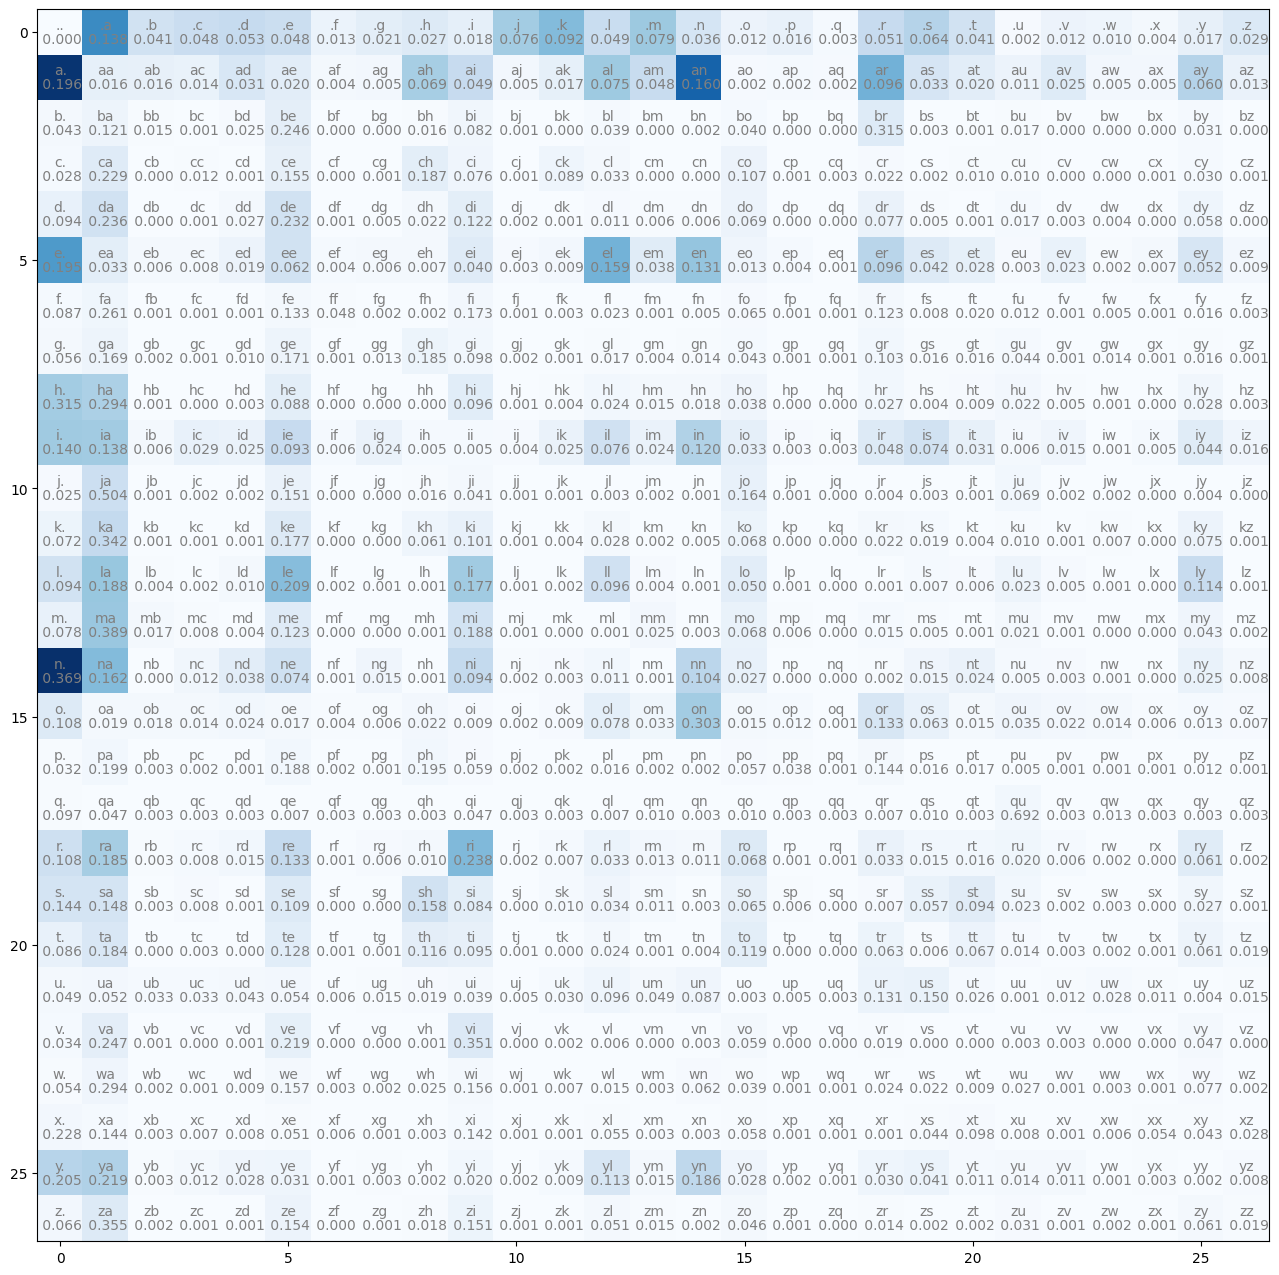

In [15]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
  for j in range(27):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
    plt.text(j, i, f"{P[i,j].item(): 0.3f}", ha='center', va='top', color='gray')

#### Evaluating the Probability Distribution Method's Performance

In [17]:
# Calculating the loss
log_likelihood = 0
n = 0
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1, ix2 = stoi[ch1], stoi[ch2]
    prob = P[ix1, ix2]
    logProb = torch.log(prob)
    log_likelihood += logProb
    n += 1
    #print(f'{ch1}{ch2}: {prob:.4f} {logProb:.4f}')
print(f'Log Likelihood: {log_likelihood:.4f}')
nnl = -log_likelihood
print(f'NNL: {nnl:.4f}')
print(f'Normalized NNL: {nnl/n:.4f}')

Log Likelihood: -559951.5625
NNL: 559951.5625
Normalized NNL: 2.4544


## Implementing Neural Nets

#### Getting Training Data

In [18]:
# creating training set of bigrams
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1, ix2 = stoi[ch1], stoi[ch2]
    xs.append(ix1); ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print(f"number of examples: {num}")

# Initializing the network weights
g = torch.Generator().manual_seed(2147483647) # ensuring a deterministic model
W = torch.randn((27, 27), generator=g, requires_grad=True) # initializing weights

number of examples: 228146


In [19]:
# Gradient descent
import torch.nn.functional as F
for k in range(100):
  # Forward Pass
  xenc = F.one_hot(xs, num_classes=27).float() # encoding our inputs
  logits = xenc @ W # log-counts
  # softmax
  counts = logits.exp()
  probs = counts/ counts.sum(1, keepdims=True)
  # loss calculation
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
  print(f"loss: {loss.item()}")

  # backward pass
  W.grad = None # zero grad
  loss.backward()

  # Updating weights
  W.data += -50 * W.grad

loss: 3.7686190605163574
loss: 3.3788068294525146
loss: 3.161090850830078
loss: 3.0271859169006348
loss: 2.9344842433929443
loss: 2.8672313690185547
loss: 2.816654682159424
loss: 2.777146577835083
loss: 2.745253801345825
loss: 2.7188303470611572
loss: 2.696505546569824
loss: 2.6773719787597656
loss: 2.6608052253723145
loss: 2.6463515758514404
loss: 2.633665084838867
loss: 2.622471570968628
loss: 2.6125476360321045
loss: 2.6037068367004395
loss: 2.595794916152954
loss: 2.5886809825897217
loss: 2.5822560787200928
loss: 2.5764293670654297
loss: 2.5711238384246826
loss: 2.566272735595703
loss: 2.5618226528167725
loss: 2.5577263832092285
loss: 2.5539441108703613
loss: 2.550442695617676
loss: 2.5471925735473633
loss: 2.5441696643829346
loss: 2.5413525104522705
loss: 2.538722038269043
loss: 2.536262035369873
loss: 2.5339581966400146
loss: 2.531797409057617
loss: 2.5297679901123047
loss: 2.527859926223755
loss: 2.5260636806488037
loss: 2.5243709087371826
loss: 2.522773027420044
loss: 2.5212638

In [ ]:
# Sampling from the neural nets
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
  out = []
  ix = 0
  while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # log-counts
    counts = logits.exp()
    p = counts/ counts.sum(1, keepdims=True)

    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchthizarie.


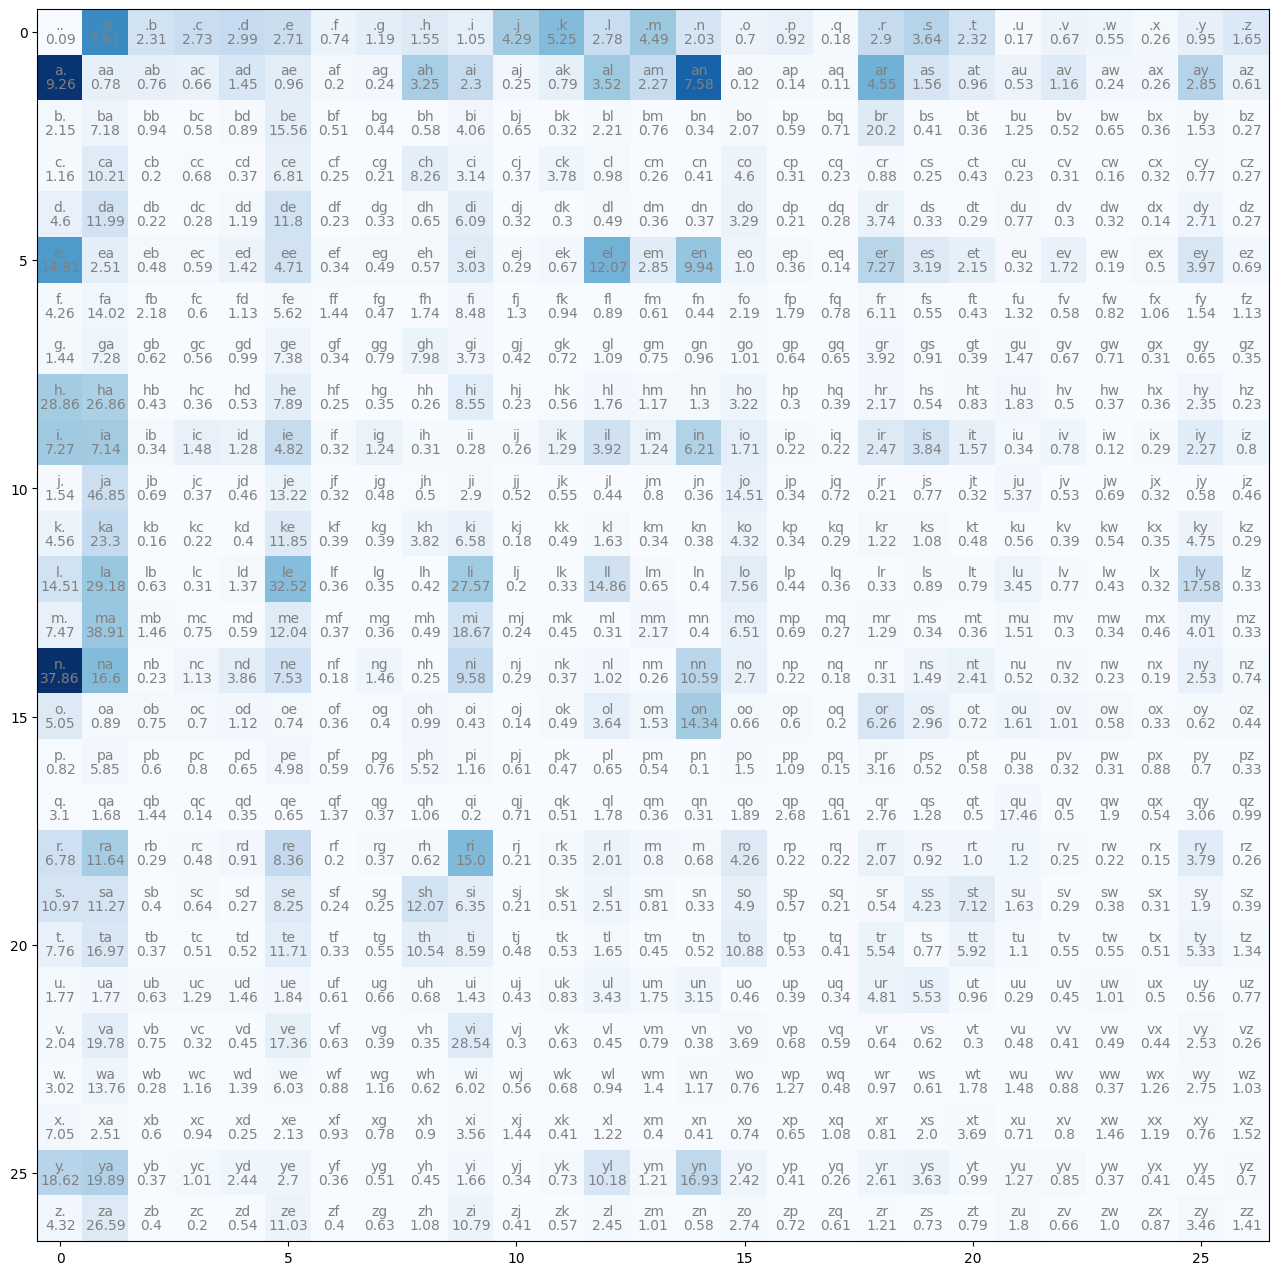

In [20]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
  for j in range(27):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
    plt.text(j, i, round(W[i,j].exp().item(), 2), ha='center', va='top', color='gray')

In [ ]:
import pandas as pd
df = pd.data

#### Credits: https://www.youtube.com/watch?v=PaCmpygFfXo